<a href="https://colab.research.google.com/github/nichepah/ml-colab/blob/master/bof.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Predict tap temperature in a Basic Oxygen Furnace using ANN

[link text](https://)**Learning Objectives:**
  * Define a neural network (NN) and its hidden layers using the TensorFlow `DNNRegressor` class
  * Train a neural network to learn nonlinearities in a dataset and achieve better performance than a linear regression model

In the previous exercises, we used synthetic features to help our model incorporate nonlinearities.

One important set of nonlinearities was around latitude and longitude, but there may be others.

We'll also switch back, for now, to a standard regression task, rather than the logistic regression task from the previous exercise. That is, we'll be predicting `median_house_value` directly.

## Setup

First, let's load and prepare the data.

,scrap,silicon,Mn,C,S,P,hot_metal_weight,blow_duration,lime,iron_ore,dolo,sinter,temp,O2,basicity,FeO
count,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0,1708.0
mean,10.4,0.8,0.1,0.0,0.0,0.1,108.3,-0.6,9335.2,2185.8,1195.2,0.0,1562.6,6605.3,2.0,8.1
std,4.6,0.3,0.0,0.0,0.0,0.0,38.3,196.9,1460.6,1371.6,1003.8,0.0,379.3,824.5,1.3,9.8
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1435.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,9.7,0.8,0.1,0.0,0.0,0.1,117.3,18.0,8346.0,1131.8,0.0,0.0,1631.0,6349.8,1.5,1.3
50%,11.4,0.9,0.1,0.0,0.0,0.1,121.3,24.0,9300.0,2045.0,1062.0,0.0,1655.0,6600.0,2.5,2.3
75%,13.1,1.0,0.1,0.0,0.0,0.1,124.4,30.0,10158.8,3020.2,1844.2,0.0,1676.0,6861.0,3.0,18.8
max,30.3,2.4,0.9,0.0,0.1,0.2,180.5,449.0,15729.0,8790.0,5211.0,0.0,1765.0,28690.0,9.2,55.0


Index(['converter', 'scrap', 'silicon', 'Mn', 'C', 'S', 'P', 'charging_time',
       'hot_metal_weight', 'blow_start', 'blow_end', 'blow_duration_hh_mm',
       'blow_duration', 'lime', 'iron_ore', 'dolo', 'sinter', 'temp',
       'tap_time', 'O2', 'basicity', 'FeO'],
      dtype='object')

----silicon.describe


count   1708.0
mean       0.8
std        0.3
min        0.0
25%        0.8
50%        0.9
75%        1.0
max        2.4
Name: silicon, dtype: float64

----scrap.describe


count   1708.0
mean      10.4
std        4.6
min        0.0
25%        9.7
50%       11.4
75%       13.1
max       30.3
Name: scrap, dtype: float64

----dtypes
 converter               object
scrap                  float64
silicon                float64
Mn                     float64
C                        int64
S                      float64
P                      float64
charging_time           object
hot_metal_weight       float64
blow_start              object
blow_end                object
blow_duration_hh_mm     object
blow_duration            int64
lime                     int64
iron_ore                 int64
dolo                     int64
sinter                   int64
temp                     int64
tap_time                object
O2                       int64
basicity               float64
FeO                    float64
dtype: object
----shape
 (1708, 22)
----numeric_cols
 ['scrap' 'silicon' 'Mn' 'C' 'S' 'P' 'hot_metal_weight' 'blow_duration'
 'lime' 'iron_ore' 'dolo' 'sinter' 'temp' 'O2' 'basicity' 'FeO']
----non-numeric_cols
 ['converter' 'charging_time' 'blow_start' 'blow_end' 'blow_duration_hh_mm'
 'tap_time']


,scrap,silicon,Mn,C,S,P,hot_metal_weight,blow_duration,lime,iron_ore,dolo,sinter,temp,O2,basicity,FeO
count,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0,1320.0
mean,10.6,0.8,0.1,0.0,0.0,0.1,122.0,24.9,9356.2,2270.8,1212.5,0.0,1654.1,6614.4,2.0,8.0
std,4.3,0.3,0.0,0.0,0.0,0.0,6.5,7.9,1437.0,1369.9,984.8,0.0,41.0,762.4,1.2,9.7
min,0.0,0.0,0.0,0.0,0.0,0.0,91.6,11.0,3633.0,0.0,0.0,0.0,1263.0,2497.0,0.0,0.0
25%,9.8,0.8,0.1,0.0,0.0,0.1,119.2,18.0,8427.8,1240.5,125.2,0.0,1636.0,6354.8,1.5,1.3
50%,11.4,0.9,0.1,0.0,0.0,0.1,122.0,24.0,9328.5,2104.5,1084.5,0.0,1656.0,6580.0,2.5,2.3
75%,12.9,1.0,0.1,0.0,0.0,0.1,125.0,29.0,10182.8,3106.0,1890.0,0.0,1676.2,6851.5,3.0,18.6
max,30.3,2.4,0.9,0.0,0.1,0.2,180.5,49.0,15729.0,8790.0,4809.0,0.0,1760.0,28690.0,9.2,55.0


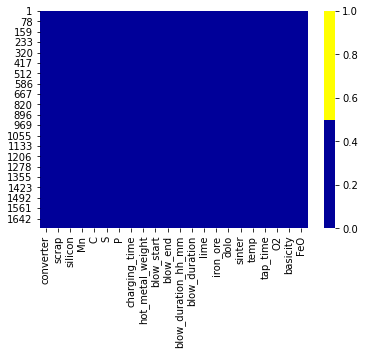

In [28]:
from __future__ import print_function
 
import math
 
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset
 
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 50
pd.options.display.float_format = '{:.1f}'.format
 
# add lineterminator too, else it might result in parse error; check in gedit to see the actual formatted data
# raw is better than https://github.com/nichepah/ml-colab/blob/master/bof.csv 
bof_temp_dataframe = pd.read_csv("https://raw.githubusercontent.com/nichepah/ml-colab/master/bof_train.csv", sep=",")
 
# just make sure that what goes is exactly as what you intend to do
display.display(bof_temp_dataframe.describe())
# show just columns
display.display(bof_temp_dataframe.columns)
# show wtf is going on with silicon
print('----silicon.describe')
display.display(bof_temp_dataframe['silicon'].describe())
# compare it with scrap
print('----scrap.describe')
display.display(bof_temp_dataframe['scrap'].describe())
print("----dtypes\n",bof_temp_dataframe.dtypes)
print("----shape\n",bof_temp_dataframe.shape)
 
df_numeric = bof_temp_dataframe.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print("----numeric_cols\n",numeric_cols)
 
df_non_numeric = bof_temp_dataframe.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print("----non-numeric_cols\n",non_numeric_cols)
 
# silicon went into non-numeric, may be some erroneous data
# for cleaning data https://towardsdatascience.com/data-cleaning-in-python-the-ultimate-guide-2020-c63b88bf0a0d
# also refer https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html
df = bof_temp_dataframe.dropna(subset=['hot_metal_weight']) 
df = df[df.hot_metal_weight > 90]
df = df[df.temp > 1200]
df = df[(df.blow_duration > 10) &(df.blow_duration < 50)]
display.display(df.describe())
cols = df.columns[:30] # first 30 
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))# print("----dtypes of df \n",b.dtypes)
bof_temp_dataframe = df
bof_temp_dataframe = bof_temp_dataframe.reindex(
    np.random.permutation(bof_temp_dataframe.index))

In [29]:
def preprocess_features(bof_temp_dataframe):
  """Prepares input features from the temp data set.
 
  Args:
    bof_temp_dataframe: A Pandas DataFrame expected to contain data
      from the bof data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = bof_temp_dataframe[
    ["scrap",
     "silicon",
     "Mn",
     "C",
     "S",
     "P",
     "hot_metal_weight",
     "blow_duration",
     "lime",
     "iron_ore",
     "dolo",
     "sinter",
     "O2",
     "basicity",
     "FeO"]]
  processed_features = selected_features.copy()
  # scaling of lime, iron, dolo may be taken up here
  # Create a synthetic feature.
  # processed_features["new_col"] = (
  # bof_temp_dataframe["col1"] /
  #  bof_temp_dataframe["col2"])
  processed_features["hot_metal_weight"] = bof_temp_dataframe["hot_metal_weight"]*1000
  return processed_features
 
def preprocess_targets(bof_temp_dataframe):
  """Prepares target features (i.e., labels) from the data set.
 
  Args:
    bof_temp_dataframe: A Pandas DataFrame expected to contain data
      from the bof data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # No need to scale the target.
  output_targets["temp"] = (
    bof_temp_dataframe["temp"])
  return output_targets

In [31]:
# Choose the first 1000 out of 1392 examples for training.
training_examples = preprocess_features(bof_temp_dataframe.head(1000))
training_targets = preprocess_targets(bof_temp_dataframe.head(1000))
 
# Choose the last 392 out of 1392 examples for validation.
validation_examples = preprocess_features(bof_temp_dataframe.tail(320))
validation_targets = preprocess_targets(bof_temp_dataframe.tail(320))
 
# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())
 
print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,scrap,silicon,Mn,C,S,P,hot_metal_weight,blow_duration,lime,iron_ore,dolo,sinter,O2,basicity,FeO
count,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
mean,10.6,0.8,0.1,0.0,0.0,0.1,122036.4,25.0,9370.6,2284.2,1227.6,0.0,6629.7,2.0,8.2
std,4.3,0.3,0.0,0.0,0.0,0.0,6530.5,7.9,1425.7,1386.2,988.9,0.0,834.8,1.3,9.8
min,0.0,0.0,0.0,0.0,0.0,0.0,91600.0,12.0,3633.0,0.0,0.0,0.0,2761.0,0.0,0.0
25%,9.8,0.8,0.1,0.0,0.0,0.1,119200.0,18.0,8435.2,1240.5,198.8,0.0,6354.8,1.5,1.3
50%,11.4,0.9,0.1,0.0,0.0,0.1,122000.0,24.0,9367.5,2104.5,1092.0,0.0,6598.5,2.5,2.3
75%,13.1,1.0,0.1,0.0,0.0,0.1,125000.0,29.0,10194.8,3139.2,1950.0,0.0,6858.5,3.0,18.7
max,30.3,1.6,0.8,0.0,0.1,0.2,180500.0,49.0,15729.0,8790.0,4809.0,0.0,28690.0,9.2,55.0


Validation examples summary:


,scrap,silicon,Mn,C,S,P,hot_metal_weight,blow_duration,lime,iron_ore,dolo,sinter,O2,basicity,FeO
count,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0
mean,10.5,0.8,0.1,0.0,0.0,0.1,121929.7,24.7,9311.2,2229.0,1165.4,0.0,6566.3,2.0,7.5
std,4.4,0.3,0.1,0.0,0.0,0.0,6490.9,8.0,1473.0,1318.8,971.9,0.0,467.2,1.2,9.4
min,0.0,0.0,0.0,0.0,0.0,0.0,92000.0,11.0,3984.0,0.0,0.0,0.0,2497.0,0.0,0.0
25%,9.7,0.8,0.1,0.0,0.0,0.1,119000.0,18.0,8388.8,1250.8,0.0,0.0,6353.8,1.5,1.3
50%,11.4,0.9,0.1,0.0,0.0,0.1,122000.0,24.0,9273.0,2103.0,1026.0,0.0,6557.5,2.3,2.3
75%,12.7,1.0,0.1,0.0,0.0,0.1,125000.0,28.0,10120.5,2998.5,1795.5,0.0,6836.2,2.9,17.9
max,25.0,2.4,0.9,0.0,0.1,0.2,139600.0,49.0,14316.0,7445.0,4137.0,0.0,7918.0,4.9,32.1


Training targets summary:


,temp
count,1000.0
mean,1653.5
std,42.7
min,1263.0
25%,1636.0
50%,1656.0
75%,1676.0
max,1760.0


Validation targets summary:


,temp
count,320.0
mean,1656.0
std,35.2
min,1474.0
25%,1639.8
50%,1657.0
75%,1677.2
max,1756.0


## Build the Network

The NN is defined by the [DNNRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNRegressor) class.

Use **`hidden_units`** to define the structure of the NN.  The `hidden_units` argument provides a list of ints, where each int corresponds to a hidden layer and indicates the number of nodes in it.  For example, consider the following assignment:

`hidden_units=[3,10]`

The preceding assignment specifies a neural net with two hidden layers:

* The first hidden layer contains 3 nodes.
* The second hidden layer contains 10 nodes.

If we wanted to add more layers, we'd add more ints to the list. For example, `hidden_units=[10,20,30,40]` would create four layers with ten, twenty, thirty, and forty units, respectively.

By default, all hidden layers will use ReLu activation and will be fully connected.

In [32]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.
 
  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [33]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [34]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `bof_temp_dataframe` to use as input features for training.
  
  Returns:
    A `DNNRegressor` object trained on the training data.
  """
 
  periods = 10
  steps_per_period = steps / periods
  
  # Create a DNNRegressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer,
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["temp"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["temp"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["temp"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
 
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")
 
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()
 
  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)
 
  return dnn_regressor

## Task 1: Train a NN Model

**Adjust hyperparameters, aiming to drop RMSE below 110.**

Run the following block to train a NN model.  

Recall that in the linear regression exercise with many features, an RMSE of 110 or so was pretty good.  We'll aim to beat that.

Your task here is to modify various learning settings to improve accuracy on validation data.

Overfitting is a real potential hazard for NNs.  You can look at the gap between loss on training data and loss on validation data to help judge if your model is starting to overfit. If the gap starts to grow, that is usually a sure sign of overfitting.

Because of the number of different possible settings, it's strongly recommended that you take notes on each trial to help guide your development process.

Also, when you get a good setting, try running it multiple times and see how repeatable your result is. NN weights are typically initialized to small random values, so you should see differences from run to run.


Training model...
RMSE (on training data):
  period 00 : 335.58
  period 01 : 336.99
  period 02 : 333.03
  period 03 : 327.52
  period 04 : 321.69
  period 05 : 315.40
  period 06 : 312.22
  period 07 : 303.54
  period 08 : 293.97
  period 09 : 284.39
Model training finished.
Final RMSE (on training data):   284.39
Final RMSE (on validation data): 278.98


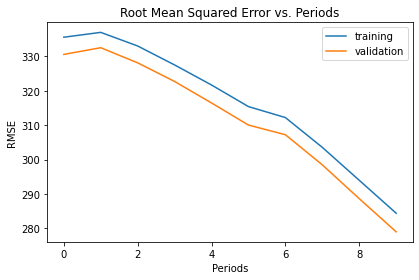

In [13]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    hidden_units=[10, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### Solution

Click below to see a possible solution

**NOTE:** This selection of parameters is somewhat arbitrary. Here we've tried combinations that are increasingly complex, combined with training for longer, until the error falls below our objective (training is nondeterministic, so results may fluctuate a bit each time you run the solution). This may not be the best combination; others may attain an even lower RMSE. If your aim is to find the model that can attain the best error, then you'll want to use a more rigorous process, like a parameter search.

Training model...
RMSE (on training data):
  period 00 : 284.79
  period 01 : 282.14
  period 02 : 281.39
  period 03 : 337.93
  period 04 : 351.44
  period 05 : 350.63
  period 06 : 349.72
  period 07 : 348.87
  period 08 : 347.93
  period 09 : 347.10
Model training finished.
Final RMSE (on training data):   347.10
Final RMSE (on validation data): 334.06


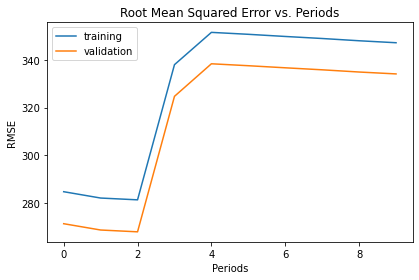

In [35]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=500,
    batch_size=10,
    hidden_units=[15, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)


## Modified with smaller step size




## Task 2: Evaluate on Test Data

**Confirm that your validation performance results hold up on test data.**

Once you have a model you're happy with, evaluate it on test data to compare that to validation performance.

Reminder, the test data set is located [here](https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv).

Training model...
RMSE (on training data):
  period 00 : 13022.81
  period 01 : 7725.60
  period 02 : 2522.86
  period 03 : 1550.81
  period 04 : 862.70
  period 05 : 1291.49
  period 06 : 816.76
  period 07 : 1265.38
  period 08 : 812.74
  period 09 : 1398.95
Model training finished.
Final RMSE (on training data):   1398.95
Final RMSE (on validation data): 1328.86


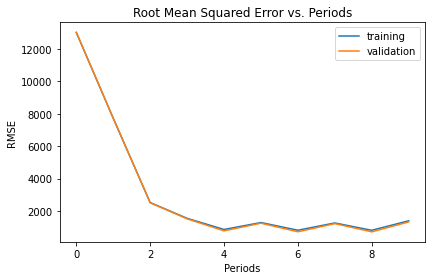

In [36]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=50,
    batch_size=10,
    hidden_units=[15, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)


With smaller step size, higher learning rate

Training model...
RMSE (on training data):
  period 00 : 5803.57
  period 01 : 5345.54
  period 02 : 4883.48
  period 03 : 4412.82
  period 04 : 3937.80
  period 05 : 3463.34
  period 06 : 2975.45
  period 07 : 2494.46
  period 08 : 1225.83
  period 09 : 343.02
Model training finished.
Final RMSE (on training data):   343.02
Final RMSE (on validation data): 346.69


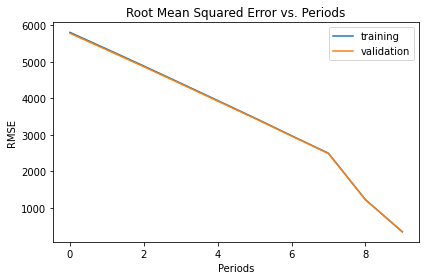

In [37]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    hidden_units=[15, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)


Increase batch size

Training model...
RMSE (on training data):
  period 00 : 1375.23
  period 01 : 892.56
  period 02 : 642.65
  period 03 : 121.00
  period 04 : 433.87
  period 05 : 546.70
  period 06 : 156.86
  period 07 : 222.29
  period 08 : 408.23
  period 09 : 470.76
Model training finished.
Final RMSE (on training data):   470.76
Final RMSE (on validation data): 473.82


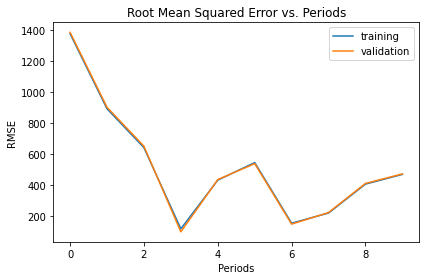

In [38]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=20,
    hidden_units=[15, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)


Reduce step size

Training model...
RMSE (on training data):
  period 00 : 1967.45
  period 01 : 1827.29
  period 02 : 2257.59
  period 03 : 2117.91
  period 04 : 2281.73
  period 05 : 2361.87
  period 06 : 2240.28
  period 07 : 2113.76
  period 08 : 1839.14
  period 09 : 1711.70
Model training finished.
Final RMSE (on training data):   1711.70
Final RMSE (on validation data): 1711.95


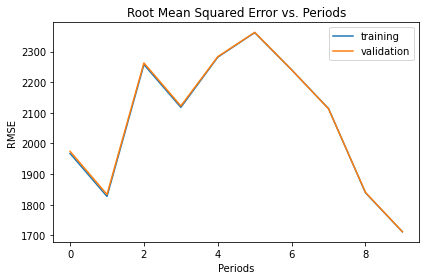

In [39]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=100,
    batch_size=20,
    hidden_units=[15, 10, 5],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Case 1 with increased batch size


Training model...
RMSE (on training data):
  period 00 : 486.45
  period 01 : 108.35
  period 02 : 152.46
  period 03 : 142.89
  period 04 : 143.53
  period 05 : 142.90
  period 06 : 148.44
  period 07 : 148.27
  period 08 : 148.35
  period 09 : 149.28
Model training finished.
Final RMSE (on training data):   149.28
Final RMSE (on validation data): 149.43


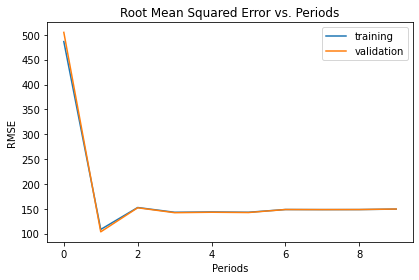

In [40]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=20,
    hidden_units=[10, 2],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Try to increase complexity


Training model...
RMSE (on training data):
  period 00 : 265.60
  period 01 : 267.24
  period 02 : 241.20
  period 03 : 228.21
  period 04 : 214.28
  period 05 : 211.48
  period 06 : 205.69
  period 07 : 194.48
  period 08 : 188.59
  period 09 : 190.17
Model training finished.
Final RMSE (on training data):   190.17
Final RMSE (on validation data): 188.17


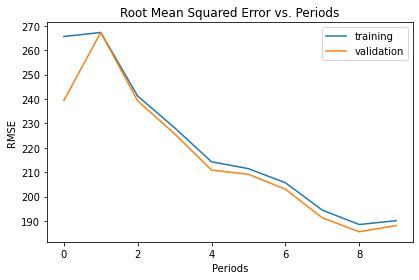

In [46]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=50,
    hidden_units=[15, 5],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [ ]:
bof_temp_test_data = pd.read_csv("https://raw.githubusercontent.com/nichepah/ml-colab/master/bof_test.csv", sep=",")
 
# YOUR CODE HEREbof_temp_dataframe

### Solution

Click below to see a possible solution.

Similar to what the code at the top does, we just need to load the appropriate data file, preprocess it and call predict and mean_squared_error.

Note that we don't have to randomize the test data, since we will use all records.

In [47]:
from google.colab import drive
drive.mount('drive')

bof_temp_test_data = pd.read_csv("https://raw.githubusercontent.com/nichepah/ml-colab/master/bof_test.csv", sep=",")
 
test_examples = preprocess_features(bof_temp_test_data)
test_targets = preprocess_targets(bof_temp_test_data)
 
predict_testing_input_fn = lambda: my_input_fn(test_examples, 
                                               test_targets["temp"], 
                                               num_epochs=1, 
                                               shuffle=False)
 
test_predictions = dnn_regressor.predict(input_fn=predict_testing_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])
print("----test_predictions")
print(test_predictions, test_targets["temp"])
# save data and prediction to drive
my_df = pd.DataFrame(data=bof_temp_test_data)
my_df['p_temp'] = test_predictions
my_df.to_csv('pred.csv')
!cp pred.csv "drive/My Drive/myCoLab/"
display.display(my_df.describe)
root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))
 
print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
----test_predictions
[1417.1498 1528.1677 1404.6973 1409.4435 1461.5634 1334.1486 1415.0841
 1630.8547 1569.0292 1560.1667 1394.7845 1463.0956 1466.1272 1437.1881
 1543.8235 1490.0436 1477.8589 1358.9347 1670.1492 1277.9227 1596.949
 1585.744  1562.4987 1506.0463 1279.0183 1618.6339 1295.4342 1537.0734
 1586.8939 1246.264  1601.5089 1520.487  1526.5621 1500.0913 1592.2068
 1533.5566 1152.644  1688.5381 1714.0316 1781.1713 1790.5984 1761.4308
 1774.2747 1678.5403 1694.0905 1458.6017 1523.8511 1507.0552 1557.0802
 1486.7059 1356.5277 1478.34   1434.7649 1417.188  1543.3982 1502.1016
 1376.5702 1472.9169 1364.0739 1370.3187 1530.8057 1456.7875 1263.0872
 1340.6091 1274.8762 1453.2604 1357.6368 1495.7963 1557.9498 1350.4156
 1467.1073 1269.251  1398.458  1456.955  1405.0146 1245.7515 1240.8673
 1331.5665 1343.902 ] 0     1623
1     1616
2     1680
3     1685
4     1700
      ... 


<bound method NDFrame.describe of    converter  scrap  silicon  Mn  C  ...  tap_time    O2 basicity  FeO p_temp
0          A    0.0      0.9 0.1  0  ...     11:36  4044      2.8 21.0 1417.1
1          A   10.7      1.2 0.1  0  ...     12:36  7023      2.7 19.4 1528.2
2          A   11.6      1.2 0.1  0  ...     13:11  7110      0.0  0.0 1404.7
3          A   13.2      0.9 0.1  0  ...     13:31  6540      3.0  4.8 1409.4
4          B    9.7      0.9 0.1  0  ...     14:30  6508      0.0  0.0 1461.6
..       ...    ...      ...  .. ..  ...       ...   ...      ...  ...    ...
74         A   12.4      0.9 0.1  0  ...     12:55  6359      0.0  0.0 1405.0
75         B   11.2      1.2 0.1  0  ...     17:35  6220      1.5  1.9 1245.8
76         B   12.6      1.2 0.1  0  ...     18:19  6550      0.0  0.0 1240.9
77         B   12.2      0.9 0.1  0  ...     19:22  5841      0.0  0.0 1331.6
78         C   11.6      0.9 0.1  0  ...     23:54  6178      0.0  0.0 1343.9

[79 rows x 23 columns]>

Final RMSE (on test data): 235.18
